<a href="https://colab.research.google.com/github/LGavin1/ALS-Disease-Progression/blob/main/ALS_progress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pylab as pl
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import xgboost
from xgboost.sklearn import XGBRegressor

from plotnine import *
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
import sys
!pip3 install xgboost==0.7.post4

# Load R-preprocessed ALS data

In [ ]:
als_final = pd.read_csv('ALS_FINAL.csv', index_col=0)

# Split train and test dataset

In [ ]:
als_final.columns

Index(['subject_id', 'Q1_Speech', 'Q2_Salivation', 'Q3_Swallowing',
       'Q4_Handwriting', 'Q5a_Cutting_without_Gastrostomy',
       'Q6_Dressing_and_Hygiene', 'Q7_Turning_in_Bed', 'Q8_Walking',
       'Q9_Climbing_Stairs', 'Q10_Respiratory', 'ALSFRS_Delta', 'ALSFRS_Total',
       'ALSFRS_Slope', 'famhis', 'Age', 'Ethnicity', 'Race_Caucasian', 'Sex',
       'Study_Arm', 'Onset_Delta', 'Bulbar_Onset', 'Limb_Bulbar_Onset',
       'Limb_Onset', 'Spine_Onset', 'Other_Onset',
       'FVC_Subject_Liters_Trial_1', 'Forced_Vital_Capacity_Delta',
       'Blood_Pressure_Diastolic', 'Blood_Pressure_Systolic', 'Pulse',
       'Respiratory_Rate', 'Temperature', 'Weight', 'Vital_Signs_Delta', 'AEC',
       'ALT', 'AST', 'Blood.Urea.Nitrogen..BUN.', 'Chloride', 'Creatinine',
       'Glucose', 'Hematocrit', 'Hemoglobin', 'Platelets', 'Potassium', 'RBC',
       'Sodium', 'WBC'],
      dtype='object')

In [ ]:
als_final['ALSFRS_Slope'].min()

-0.5

### Keep als_12 untouched until making final prediction

In [ ]:
als_3 = als_final[(als_final['ALSFRS_Delta'] >= 0) & (als_final['ALSFRS_Delta'] <= 90)]
als_12 = als_final[(als_final['ALSFRS_Delta'] > 90) & (als_final['ALSFRS_Delta'] <= 366)]

In [ ]:
als_3.shape

(633, 49)

In [ ]:
als_12.shape

(3421, 49)

In [ ]:
X = als_3.drop(['subject_id', 'ALSFRS_Slope'],axis=1)
y = als_3['ALSFRS_Slope']

In [ ]:
X.shape

(633, 47)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
X_als12 =als_12.drop(['subject_id', 'ALSFRS_Slope'], axis=1)
y_als12 = als_12['ALSFRS_Slope']

# Scale and dimensionality reduction

In [ ]:
# scale
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
X_train_scaled

array([[7.50000000e-01, 7.50000000e-01, 1.00000000e+00, ...,
        2.71061730e-06, 4.96478873e-01, 2.42622951e-01],
       [0.00000000e+00, 5.00000000e-01, 2.50000000e-01, ...,
        2.29425288e-06, 4.15978630e-01, 2.89429056e-01],
       [7.50000000e-01, 1.00000000e+00, 5.00000000e-01, ...,
        2.36298943e-06, 3.92018779e-01, 5.73770492e-01],
       ...,
       [2.50000000e-01, 5.00000000e-01, 5.00000000e-01, ...,
        2.40183826e-06, 4.27277953e-01, 2.24610237e-01],
       [5.00000000e-01, 5.00000000e-01, 5.00000000e-01, ...,
        3.01864199e-06, 4.13639733e-01, 3.83904620e-01],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        2.54428396e-06, 4.92957747e-01, 2.22950820e-01]])

In [ ]:
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train_scaled)

In [ ]:
X_val_reduced = pca.transform(X_val_scaled)

In [ ]:
pca.n_components_

25

In [ ]:
X_train_reduced.shape

(569, 25)

In [ ]:
np.sum(pca.explained_variance_ratio_)

0.9544065720861014

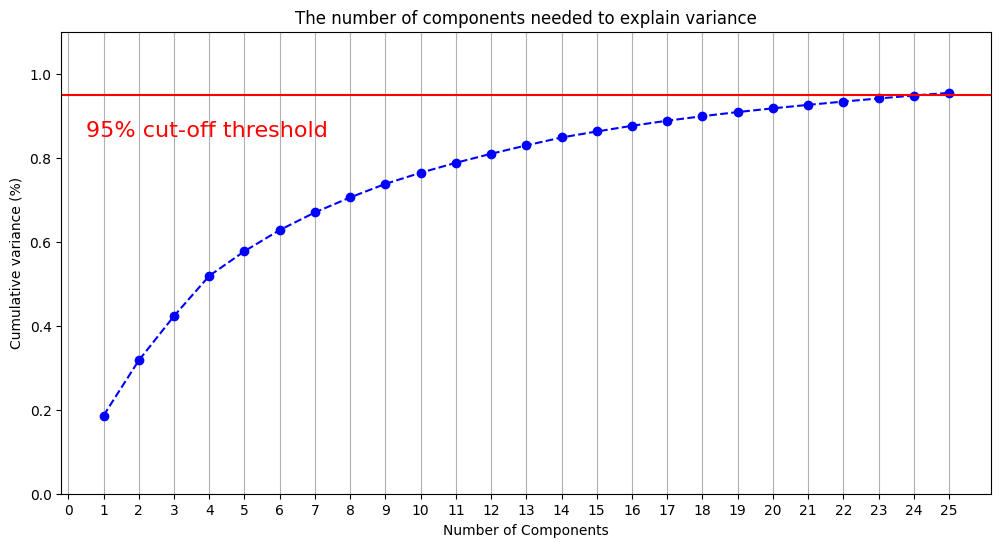

In [ ]:
plt.rcParams['figure.figsize'] = (12,6)
fig, ax = plt.subplots()
xi = np.arange(1,26,step=1)
y = np.cumsum(pca.explained_variance_ratio_)
plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 26, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

# Train different models, predict, and evaluate

## Random forest

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
rnd_reg = RandomForestRegressor()
rnd_search = RandomizedSearchCV(estimator = rnd_reg, param_distributions=random_grid,
                               n_iter = 100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rnd_search.fit(X_train_reduced, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
print(rnd_search.best_params_)

{'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 70, 'bootstrap': False}


In [ ]:
best_model = rnd_search.best_estimator_
val_pred = best_model.predict(X_val_reduced)
val_mse = mean_squared_error(y_val, val_pred)
val_rmse = np.sqrt(val_mse)
val_rmse

0.09006130796195737

In [ ]:
train_mse = mean_squared_error(y_train, best_model.predict(X_train_reduced))
train_rmse = np.sqrt(train_mse)
train_rmse

0.030017360874823377

In [ ]:
feat_labels = list(X_train.columns)

In [ ]:
# pipeline for random forest
best_model = rnd_search.best_estimator_
rnd_pipeline = Pipeline((
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=0.95)),
    ('rnd_reg', RandomForestRegressor(n_estimators=600, min_samples_split=2, min_samples_leaf=4,
                                     max_features='log2', max_depth=60, bootstrap=False)),
))

rnd_pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', MinMaxScaler()), ('pca', PCA(n_components=0.95)),
                ('rnd_reg',
                 RandomForestRegressor(bootstrap=False, max_depth=60,
                                       max_features='log2', min_samples_leaf=4,
                                       n_estimators=600))])

In [ ]:
rnd_pipeline.predict(X_val)

array([-0.01576437, -0.03742061, -0.05196492, -0.04871738, -0.05928717,
       -0.09249573, -0.10375975, -0.03527946, -0.047212  , -0.06318432,
       -0.08092376, -0.05398769, -0.02048615, -0.02657775, -0.10722604,
       -0.0377774 , -0.05904379, -0.03896388, -0.05764233, -0.05402078,
       -0.05204718, -0.0491686 , -0.06603869, -0.088228  , -0.02521095,
       -0.0517535 , -0.07341893, -0.05317378, -0.05466401, -0.05760371,
       -0.05162565, -0.03594662, -0.09804189, -0.09547994, -0.04200744,
       -0.01471225, -0.05945261, -0.04159537, -0.04108339, -0.05943642,
       -0.03399124, -0.06449629, -0.0612043 , -0.02972153, -0.05431201,
       -0.05705412, -0.02666263, -0.06980427, -0.07164716, -0.03248876,
       -0.05208042, -0.01574835, -0.03080054, -0.04726694, -0.04261427,
       -0.02157324, -0.07281233, -0.05286376, -0.05382102, -0.06188881,
       -0.03150901, -0.04204642, -0.0785144 , -0.06144398])

In [ ]:
val_pred = rnd_pipeline.predict(X_val)
val_mse = mean_squared_error(y_val, val_pred)
val_rmse = np.sqrt(val_mse)
val_rmse

0.09033987072565303

In [ ]:
train_mse = mean_squared_error(y_train, rnd_pipeline.predict(X_train))
train_rmse = np.sqrt(train_mse)
train_rmse

0.030061551535849034

#### final als12 rnd prediction

In [ ]:
# final prediction on als12
als12_pred = rnd_pipeline.predict(X_als12)
als12_rnd_mse = mean_squared_error(y_als12, als12_pred)
als12_rnd_rmse = np.sqrt(als12_rnd_mse)
als12_rnd_rmse

0.028611617512963698

### Select best param train X_train without pca to compare differences, finding that pca didn't help, made it worse instead

In [ ]:
rnd_reg = RandomForestRegressor()
rnd_search2 = RandomizedSearchCV(estimator = rnd_reg, param_distributions=random_grid,
                               n_iter = 100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rnd_search2.fit(X_train_reduced, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
best_model2 = rnd_search2.best_estimator_
val_pred = best_model2.predict(X_val_reduced)
val_mse = mean_squared_error(y_val, val_pred)
val_rmse = np.sqrt(val_mse)
val_rmse


0.0900473483603966

In [ ]:
train_mse2 = mean_squared_error(y_train, best_model2.predict(X_train_reduced))
train_rmse2 = np.sqrt(train_mse2)
train_rmse2

0.029955523985478034

In [ ]:
features = []
for feature in zip(feat_labels, best_model2.feature_importances_):
    features.append(feature)
    #print(feature)
#features
sorted_feature = sorted(features, reverse=True, key=lambda x: x[1])
sorted_feature

[('Q1_Speech', 0.0902004977541195),
 ('Q2_Salivation', 0.06969315415992511),
 ('Q6_Dressing_and_Hygiene', 0.061436614891751604),
 ('Race_Caucasian', 0.054224963999551574),
 ('Q10_Respiratory', 0.05188018762185937),
 ('Q9_Climbing_Stairs', 0.051495913686236544),
 ('ALSFRS_Total', 0.05087962636597062),
 ('famhis', 0.04910709591947537),
 ('Q4_Handwriting', 0.04222470301972977),
 ('Q7_Turning_in_Bed', 0.04216311860696244),
 ('Q5a_Cutting_without_Gastrostomy', 0.04097730992223338),
 ('Q8_Walking', 0.03571245268877253),
 ('Limb_Onset', 0.034440939354849834),
 ('ALSFRS_Delta', 0.032779927680148105),
 ('Q3_Swallowing', 0.03059668029752937),
 ('Spine_Onset', 0.030138322373102),
 ('Other_Onset', 0.030048823802378204),
 ('Limb_Bulbar_Onset', 0.029128876530380245),
 ('Sex', 0.02706279585933641),
 ('Age', 0.026594627307452053),
 ('Onset_Delta', 0.026562000400791052),
 ('Bulbar_Onset', 0.024577406708645465),
 ('Study_Arm', 0.024033217937743837),
 ('Ethnicity', 0.02372417099799825),
 ('FVC_Subject_Li

# Select most important features to train again

In [ ]:
sfm = SelectFromModel(best_model2, threshold=0.04)
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(bootstrap=False, max_depth=80,
                                                max_features='log2',
                                                min_samples_leaf=4,
                                                n_estimators=1400),
                threshold=0.04)

In [ ]:
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

Q3_Swallowing
ALSFRS_Delta
ALSFRS_Total
Onset_Delta
Forced_Vital_Capacity_Delta
Vital_Signs_Delta


In [ ]:
X_important_train = sfm.transform(X_train)
X_important_val = sfm.transform(X_val)

In [ ]:
rnd_reg_imp = RandomForestRegressor()
rnd_search_imp = RandomizedSearchCV(estimator = rnd_reg_imp, param_distributions=random_grid,
                               n_iter = 100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rnd_search_imp.fit(X_important_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
# test rmse
best_model_imp = rnd_search_imp.best_estimator_
val_pred_imp = best_model_imp.predict(X_important_val)
val_mse_imp = mean_squared_error(y_val, val_pred_imp)
val_rmse_imp = np.sqrt(val_mse_imp)
val_rmse_imp

In [ ]:
# train rmse
train_mse_imp = mean_squared_error(y_train, best_model_imp.predict(X_important_train))
train_rmse_imp = np.sqrt(train_mse_imp)
train_rmse_imp

In [ ]:
np.mean(val_pred_imp)

In [ ]:
#plt.scatter(best_model_imp.predict(X_important_train), y_train, color='blue')
plt.plot(best_model_imp.predict(X_important_train), y_train, 'o')
m, b = np.polyfit(best_model_imp.predict(X_important_train), y_train, 1)
plt.plot(best_model_imp.predict(X_important_train), m*best_model_imp.predict(X_important_train) + b)
plt.title("Actual vs Prediction (Training set)")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [ ]:
plot_data1 = {'actuals': y_train, 'predictions': best_model_imp.predict(X_important_train)}
plot_data = pd.DataFrame(plot_data1)

In [ ]:
fig = (
    ggplot(plot_data) +
    geom_point(
        aes(x = 'predictions',
            y = 'actuals'),
        alpha = 0.5,
        color = 'brown'
    ) +
    geom_smooth(
        aes(x = 'predictions',
            y = 'actuals'),
        color = 'orange',
        size=1
    )
)
fig

In [ ]:
# final prediction on als12
best_model_imp = rnd_search_imp.best_estimator_
val_pred_imp = best_model_imp.predict(X_important_val)
val_mse_imp = mean_squared_error(y_val, val_pred_imp)
val_rmse_imp = np.sqrt(val_mse_imp)
val_rmse_imp

## Polynomial regression

Best degree 1 with RMSE 0.08984950355337337


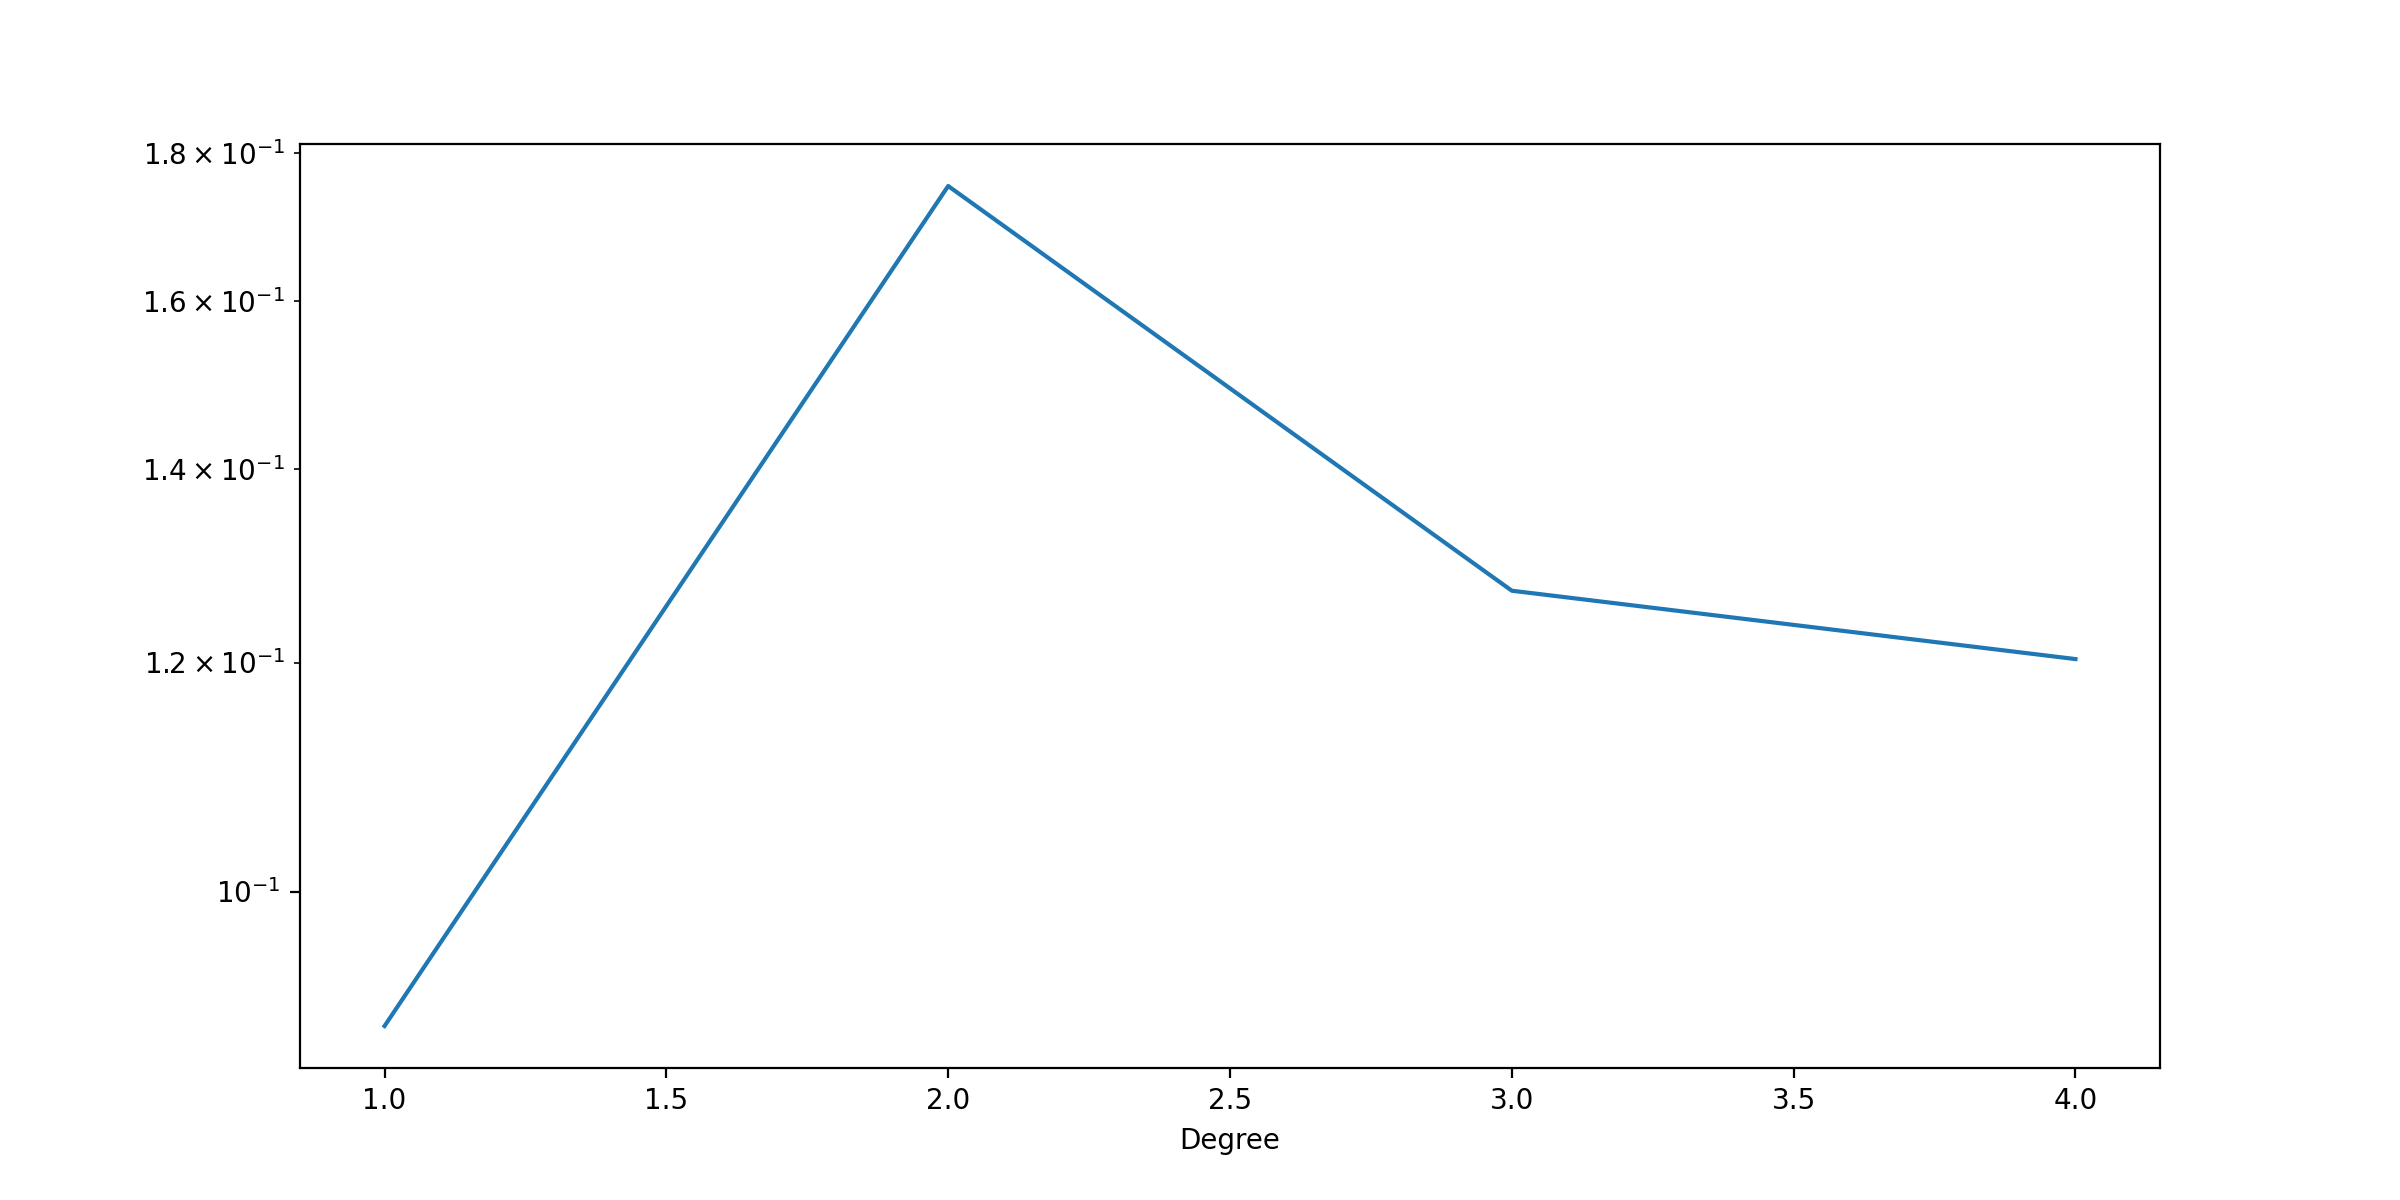

In [ ]:
# Choose the best degree parameter
rmses = []
degrees = np.arange(1,5)
min_rmse, min_deg = 1e10, 0
for deg in degrees:
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    X_poly_train = poly_features.fit_transform(X_train_scaled)

    poly_reg = LinearRegression()
    poly_reg.fit(X_poly_train, y_train)

    X_poly_val = poly_features.fit_transform(X_val_scaled)
    poly_predict = poly_reg.predict(X_poly_val)
    poly_mse = mean_squared_error(y_val, poly_predict)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)

    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg

print('Best degree {} with RMSE {}'.format(min_deg, min_rmse))

fig_poly = plt.figure()
ax = fig_poly.add_subplot(111)
ax.plot(degrees, rmses)
ax.set_yscale('log')
ax.set_xlabel('Degree')
ax.set_label('RMSE')

In [ ]:
# Use the best degree and pipleline to train data
poly_features = PolynomialFeatures(degree=1, include_bias=False)
lin_reg = LinearRegression()
polynomial_regression = Pipeline((
    ('scaler', MinMaxScaler()),
    ('poly_features', PolynomialFeatures(degree=1, include_bias=False)),
    ('lin_reg', LinearRegression()),
))

polynomial_regression.fit(X_train, y_train)

In [ ]:
# Make predictions
y_val_pred = polynomial_regression.predict(X_val)

In [ ]:
# Evaluation on val data
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
print(rmse)

In [ ]:
# Evaluation on training data
y_train_pred = polynomial_regression.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
print(rmse_train)

In [ ]:
# Plot prediction v.s. actual
plt.plot(polynomial_regression.predict(X_val), y_val, 'o')
m, b = np.polyfit(polynomial_regression.predict(X_val), y_val, 1)
plt.plot(polynomial_regression.predict(X_val), m*polynomial_regression.predict(X_val) + b)
plt.title("Actual vs Prediction (Val set)")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Predict final als_12
als12_pred = polynomial_regression.predict(X_als12)
mse12 = mean_squared_error(y_als12, als12_pred)
rmse12 = np.sqrt(mse12)
print(rmse12)

## XGBoost

In [ ]:
import scipy.stats as st
from collections.abc import Mapping
one_to_left = st.beta(10, 1)
from_zero_positive = st.expon(0, 50)

params = {
    "n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    "max_depth": [int(x) for x in np.linspace(10, 110, num = 11)],
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgb_reg = XGBRegressor(nthreads=-1)

In [ ]:
xgb_reg = RandomizedSearchCV(xgb_reg, params, n_jobs=-1)
xgb_reg.fit(X_train_scaled, y_train)

In [ ]:
print(xgb_rs.best_params_)

In [ ]:
best_xgb = xgb_rs.best_estimator_
y_val_pred = best_xgb.predict(X_val_scaled)
mse_xgb = mean_squared_error(y_val, y_val_pred)
rmse_xgb = np.sqrt(mse_xgb)
print(rmse_xgb)

In [ ]:
## pipeline of gxboost
## final als12 prediction
# pipeline for random forest
best_xgb = xgb_rs.best_estimator_
xgb_pipeline = Pipeline((
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=0.95)),
    ('xgb_reg', best_xgb),
))

xgb_pipeline.fit(X_train, y_train)

y_val_pred = xgb_pipeline.predict(X_val)
mse_xgb = mean_squared_error(y_val, y_val_pred)
rmse_xgb = np.sqrt(mse_xgb)
print(rmse_xgb)